## Overview
### Extract similar images to see what the score looks like.
#### Main use of annoy!!

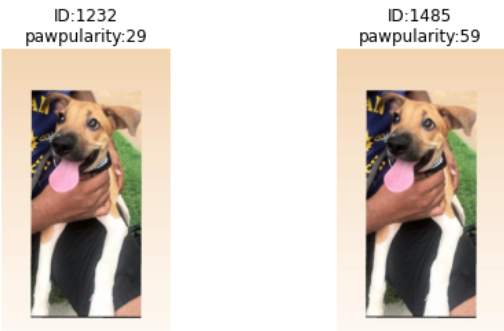
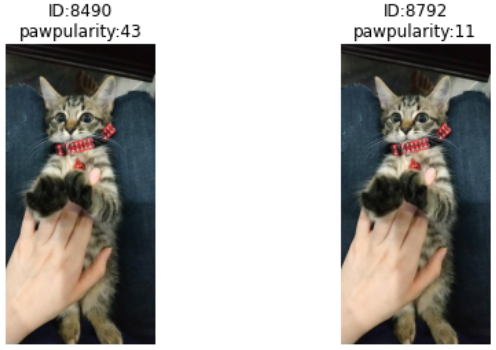

# 1. Library 

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
#TF
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential,Model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Dense,Conv2D,Flatten,Dropout, Input, Concatenate, BatchNormalization
#other
from tqdm.notebook import tqdm
import pickle
from PIL import Image
from annoy import AnnoyIndex

# 2. load dataset and set path

In [ ]:
# dataset
train_dir = "/kaggle/input/petfinder-pawpularity-score/train/"
test_dir = "/kaggle/input/petfinder-pawpularity-score/test/"
train_table = pd.read_csv("/kaggle/input/petfinder-pawpularity-score/train.csv")
test_table = pd.read_csv("/kaggle/input/petfinder-pawpularity-score/test.csv")
# set path
train_table["Id"] = train_dir + train_table["Id"] + ".jpg"
test_table["Id"] = test_dir + test_table["Id"] + ".jpg"

sample = pd.read_csv("/kaggle/input/petfinder-pawpularity-score/sample_submission.csv")
train_table.head(2)

# 3. Image feature
There are various models available, but since this is not a detailed analysis, we used mobilenet, which runs easily on cpu.

In [ ]:
def MobileNet_model():
    base_model = keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet")
    avg_pool_name = [l.name for l in base_model.layers][-2]
    x = base_model.get_layer(avg_pool_name).output
    model = Model(inputs=base_model.input, outputs=x)
    return model

def img_yield(pathes, batch_size=32, size=(224,224)):
    for i in tqdm(range(len(pathes) // batch_size+1)):
        imgs = []
        batch_pathes = pathes[i*batch_size : (1+i)*batch_size]
        if len(batch_pathes)==0: break
        for path in batch_pathes:
            img = load_img(path, target_size=size)
            img = tf.keras.applications.mobilenet_v2.preprocess_input(np.array(img))
            imgs.append(img)
        yield np.array(imgs)

In [ ]:
model = MobileNet_model()
embed_imgs = model.predict(img_yield(train_table["Id"]))
embed_imgs.shape

# 4. Build Annoy 

In [ ]:
annoy_model = AnnoyIndex(embed_imgs.shape[1])
for i, embed in enumerate(embed_imgs):
    annoy_model.add_item(i, embed)
annoy_model.build(i)

### Get N close IDs and vectors by specifying IDs.

In [ ]:
target_ID = 10
N = 5

ids, distance = annoy_model.get_nns_by_item(target_ID, N, include_distances=True)
print(ids)
print(distance)

### View and verify the actual display

In [ ]:
def show_img(ids):
    imgs = [Image.open(train_table["Id"][i]) for i in ids]
    pawpularity = [train_table["Pawpularity"][i] for i in ids]
    fig, axes = plt.subplots(1, 5, figsize=(20,8))
    for i, ax in zip(range(5), axes.ravel()):
        ax.set_title(i+1)
        ax.imshow(imgs[i])
        if i == 0:
            ax.set_title(f"[target]\nID:{ids[i]}\npawpularity:{pawpularity[i]}")
        else:
            ax.set_title(f"ID:{ids[i]}\npawpularity:{pawpularity[i]}")
        ax.axis("off")
    plt.show()

In [ ]:
show_img(ids)

# 5. distance of images

In [ ]:
distance_id = []
distance_vecotor = []
for i in tqdm(range(len(train_table["Id"]))):
    ids, distance = annoy_model.get_nns_by_item(i, 5, include_distances=True)
    distance_id.append(ids)
    distance_vecotor.append(distance)
    
distance_of_nearest_img_vecotr = np.array(distance_vecotor)[:,1]
plt.hist(distance_of_nearest_img_vecotr, bins=20)
plt.title("distance of nearest image's vecotr histgram")
plt.show()

### For now, I set the threshold to 0.4 and extracted it.

In [ ]:
threshold = 0.4
target_id = list(np.where(distance_of_nearest_img_vecotr<=threshold)[0])
check_id = [distance_id[i] for i in target_id]
print(len(target_id))

### Display the extracted image

In [ ]:
for i, ids in enumerate(check_id):
    show_img(ids)

# 6. Result

### Display the most similar image (target image, most similar image) in a DataFrame

In [ ]:
result_df = pd.DataFrame({
    "id_1":np.array(check_id)[:,0], 
    "id_2":np.array(check_id)[:,1], 
    "distance":[distance_of_nearest_img_vecotr[i] for i in target_id], 
})
result_df["id_1_Paw"] = result_df["id_1"].map(lambda i: train_table["Pawpularity"][i])
result_df["id_2_Paw"] = result_df["id_2"].map(lambda i: train_table["Pawpularity"][i])
result_df["difference"] = abs(result_df["id_1_Paw"] - result_df["id_2_Paw"])
result_df["Ave"] = (result_df["id_1_Paw"] + result_df["id_2_Paw"]) / 2
result_df

# 7. Final(impressions)
By using annoy to search for similar images, we were able to find duplicate images with differences in the objective variable.  
How to update the dataset after this is still under consideration.  
If you have any good ideas, I would be happy to hear your comments.  

Thank you for seeing this through to the end!

# 8. Additional editing (2021/11/11) 

### I will share the results I visually checked from Similar images results.
Tired...


### This is just my personal opinion, so please refer to it.

## 8-1 Image pairs that are difficult to distinguish

In [ ]:
def show_img_2(ids):
    imgs = [Image.open(train_table["Id"][i]) for i in ids]
    pawpularity = [train_table["Pawpularity"][i] for i in ids]
    fig, axes = plt.subplots(1, 2, figsize=(8,4))
    for i, ax in zip(range(2), axes.ravel()):
        ax.set_title(i+1)
        ax.imshow(imgs[i])
        ax.set_title(f"ID:{ids[i]}\npawpularity:{pawpularity[i]}")
        ax.axis("off")
    plt.show()

#### Checking the results side-by-side

In [ ]:
discriminatory_id = [[462,9849],[1232,1485],[2622,4186],[3257,7204],[3662,5587],[3721,4077],[4496,4616],[8490,8792]]
for ids in discriminatory_id:
    print("="*20,"Delete","="*20)
    show_img_2(ids)

## 8-2 Change the score of duplicate or extremely similar images.
#### The new score is the average of the two images

In [ ]:
need_process_df = pd.read_csv("../input/petfinder-new-table/pet_search.csv")
need_process_df.head(7)

In [ ]:
new_scores = need_process_df["new_score"].values

for i in range(len(need_process_df)):
    if need_process_df["new_score"][i]=="-":
        continue
    ids = list([need_process_df["id"][i], int(need_process_df["dupulicate"][i])])
    print("="*20,"Change value","="*20)
    print(f"NEW score(ave): {new_scores[i]}")
    show_img_2(ids)
    print()

## 8-3 Add delete flag and new score to original data

In [ ]:
new_train_table = train_table.copy()
# Delete flag
delete_ids = [item for l in discriminatory_id for item in l]
# Duplicate delete flag
[delete_ids.append(l) for l in list(need_process_df["id"][need_process_df["new_score"]=="-"])]
# make DELETE column
new_train_table["DELETE"] = new_train_table.index.map(lambda x:1 if x in delete_ids else 0)
# make NEW_SCORE columns
tmp = need_process_df[need_process_df["new_score"]!="-"].copy()
tmp["new_score"] = tmp["new_score"].astype(int)
new_train_table["NEW_SCORE"] = new_train_table.index.map(lambda x:tmp["new_score"][tmp["id"]==x].values[0] if x in list(tmp["id"]) else new_train_table["Pawpularity"][x])

new_train_table.head()

In [ ]:
new_train_table["DELETE"].value_counts()

In [ ]:
new_train_table[new_train_table["DELETE"]==1].head(5)

In [ ]:
new_train_table[new_train_table["Pawpularity"]!=new_train_table["NEW_SCORE"]].head(5)

In [ ]:
new_train_table.to_csv("./new_table.csv", index=None)

# 9. Additional editing (2021/12/2) 
## Score Variation

I investigated the variation of CV and LB scores with swintransformer(large_224) in the following note.  
https://www.kaggle.com/showeed/tf-swin-kfold-18-046  

Duplicate removal was a good result, but using similar images as an average process was not so good.  
I wonder how I should process them('ω')

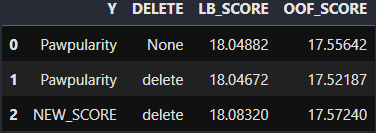

# 